# [A6] K-Means Clustering
The goal of this excercise is to implement the k-means algorithm used for cluster analysis by yourself.

# 1: Foundations
**The complete introduction of the theoretical basics is given in the lecture [_Maschinelles Lernen - Teil Laubenheimer_](https://ilias.h-ka.de/goto.php?target=crs_19086&client_id=HSKA) (slides: _ML_3_Masse.pdf_ and _ML_4_Cluster.pdf_).**

The k-means algorithm groups a set of $n$ objects, ending up with $k$ distinct groups (clusters). Each object is assigned to a cluster.

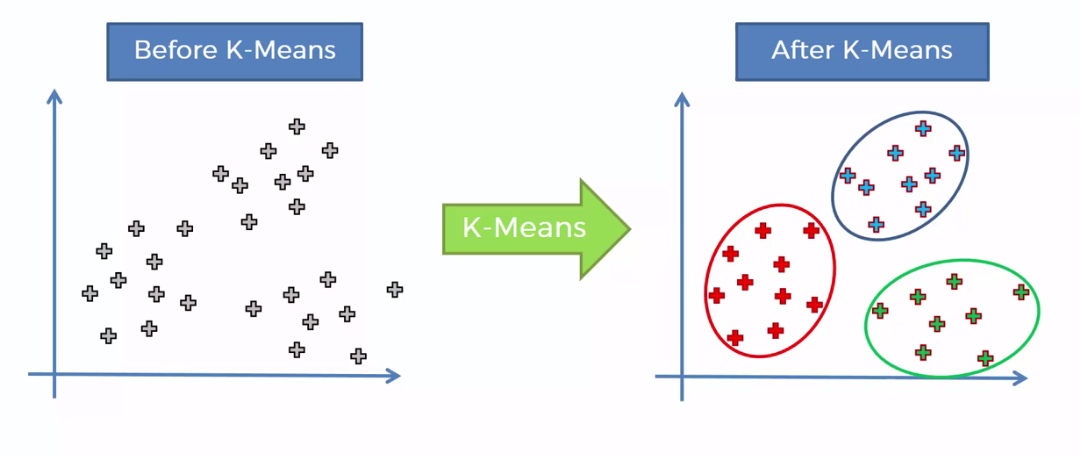

**Optimization Goal**:  The sum of the distances to the respective selected cluster centroids ("means") formed over all objects should be minimal. The squared Euclidean distance is used as the distance measure.

$$
{\displaystyle {\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\sum _{\mathbf {x} \in S_{i}}\left\|\mathbf {x} -{\boldsymbol {\mu }}_{i}\right\|^{2}}
$$

(with number of clusters: $k$ (one cluster then: $i$), objects of a cluster: $S_{i}$ (one object then: $\mathbf {x}$), centroid of a cluster: ${\boldsymbol {\mu }}_{i}$)

**Result**: The resulting cluster space consists of Voronoi cells. Every point in the space can be assigned to a cluster.

## 2: Simple Implementation
The optimization goal described above can be achieved by several methods. 

The due to its simplicity best known (but comparatively slow) method is the __naïve k-means__, also called Lloyd's algorithm.

For this algorithm, initially selected cluster centers (e.g., completely random values in space or the position of randomly selected objects of the set) are iteratively moved and objects are reassigned to clusters in each step.

### 2.1: Import Data
Before applying the k-means algorithm, data must of course be available. In this example, we use the iris data set again.

In [150]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import scipy.spatial.distance as sd
from matplotlib.colors import LinearSegmentedColormap

df = pd.read_csv("data/iris.data", header=None, sep=",", names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"])
df["class_id"] = pd.factorize(df["class"])[0]
display(df.head(2))

,sepal_length,sepal_width,petal_length,petal_width,class,class_id
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0


To keep visualizations simple we use only two features (`sepal_length` and `petal_width`). In principle however, the algorithm can be executed in any dimension.

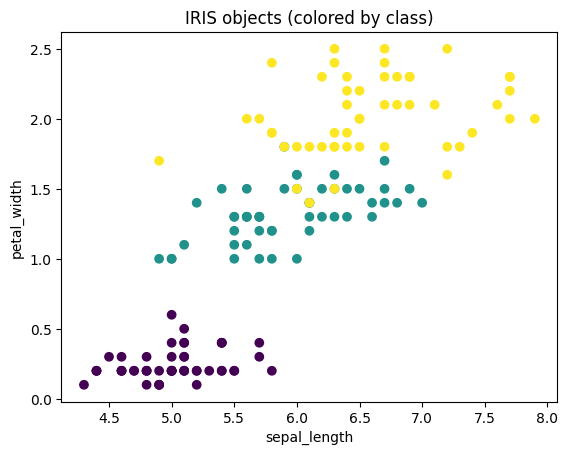

In [151]:
ax = plt.scatter(df["sepal_length"], df["petal_width"], c=df["class_id"])
plt.gca().update(dict(title='IRIS objects (colored by class)', xlabel='sepal_length', ylabel='petal_width'))
plt.show()

The classes distinguished by color here are not used by the k-means algorithm. They only serve as a comparison and to present a possible solution to the clustering problem.

To emphasize that k-means does not need any class information but only the vectors, we discard all superfluous information now.

We also remove duplicate entries that might have been created by this step.

In [152]:
iris_objects = df[["sepal_length", "petal_width"]].drop_duplicates().to_records(index=False).tolist()
iris_objects[6:10]

[(4.6, 0.3), (4.4, 0.2), (4.9, 0.1), (5.4, 0.2)]

### 2.2: ✏️ Initialization of the cluster centers
Since the iris dataset distinguishes three different types of iris plants we set the number of clusters $k=3$.

Then, for each cluster, we select a random point of the dataset as the cluster center.

1. Write a method to return a list of length k, with distinct random cluster centers (mu_i) that are all points of the dataset.

In [153]:
def get_random_cluster_centers(k, objects):
    return random.sample(objects, k)



k = 3

init_cluster_centers = get_random_cluster_centers(k, iris_objects)
init_cluster_centers

[(4.9, 1.0), (5.1, 0.4), (5.4, 1.5)]

### 2.3 Optimization of the cluster centers
For the optimization of the cluster centers, two steps are continuously carried out in alternation:

1. assigning objects to the cluster centers (_assignment_)
2. updating the cluster centers (_update_).

The algorithm ends when the assignments stop changing.

#### 2.3.1: ✏️ Assignment
Objects are always assigned to the nearest cluster center. 
Proximity is calculated using squared Euclidean distance.

**Euclidean distance**: $ \displaystyle d(\vec{x},\vec{y})=\|\vec{x}-\vec{y}\|_{2}={\sqrt {\sum _{i=1}^{n}(x_{i}-y_{i})^{2}}}$

By squaring this function, more distant objects are increasingly weighted. 
In addition, the required computational capacity decreases.

**Squared Euclidean distance**: $ \displaystyle d(\vec{x},\vec{y})=\|\vec{x}-\vec{y}\|_{2}={\sum _{i=1}^{n}(x_{i}-y_{i})^{2}}$

1. Implement the squared euclidian distance formula below. 

In [154]:
def squared_euclidean_distance(point_a, point_b, points=None):
    """Calculate the squared euclidean distance of two points"""

    # TODO: Implement
    erg = 0
    for dim in range(len(point_a)):
        erg += (point_a[dim] - point_b[dim])**2

    
    return erg
        
#squared_euclidean_distance(init_cluster_centers[0],init_cluster_centers[1])
        
    
    


2. Implement the assignment method. Important: The parameter `points` in above distance function is required later, hence the list of all objects should already be passed to the distance function.

In [155]:
def assignment(objects, cluster_centers, distance_function,all_points=None):
    """Assign each object to the nearest cluster_center
       (to the one with the least squared Euclidean distance)

    Args:
        objects (points),
        cluster_centers (points),
        distance_function (function, e.g. squared_euclidean_distance)

    Returns:
        List like this: assignments[object_id] = center_id
    """

    assignments = []  # create empty list of assignments
    
    # TODO: Implement
    
    for index_obj, object in enumerate(objects):
        temp_distance = 10000000000
        centerIndex = 0
        for index_cent, center in enumerate(cluster_centers):
            distance_calculated = distance_function(center,object,all_points)
            if distance_calculated < temp_distance:
                temp_distance = distance_calculated
                centerIndex=index_cent         
            
        #assignments[index_obj] = index_cent
        #print("index_cent", centerIndex)
        assignments.append(centerIndex)
        
    return assignments

#### 2.2.2: ✏️ Update
The cluster centers are updated based on their assigned objects.
For this purpose, the element-wise average of all these objects is calculated.

1. Implement the update method:

In [156]:
def update(k, objects, assignments):
    """Recalculate (update) the cluster_centers
       based on the objects that are assigned to each cluster

       For each cluster (center):
       (1) Determine all assigned objects
       (2) Calculate the mean of them
       (3) Set that mean as new center

    Args:
        k (int): Number of clusters
        objects (list of points)
        assignments (list): list generated above, assigning object ids to center ids

    Returns:
        list of cluster centers (points)
    """

    cluster_centers = []
    # TODO: Implement
    cluster_groups = []
    
    for dim in range(k):
        cluster_groups.append([])
    
    for index_obj, point in enumerate(assignments):
        cluster_groups[point].append(objects[index_obj])
    
    for index_clus, group in enumerate(cluster_groups):
        #cluster_centers[index_clus] = np.mean(group)
        if len(group) == 0:
            # Handle empty cluster: reinitialize to random object
            cluster_centers.append(random.choice(objects))
        else:
            cluster_centers.append(np.mean(group, axis=0))
            
    return cluster_centers


#### 2.2.3: ✏️ Loop
Keep executing _assignment_ and _update_ until the assignments do not change any longer.

1. Implement the loop method:

In [157]:
def kmeans_loop(k, objects, cluster_centers, distance_function):
    """call assignment and update till assignments no longer change"""

    print(objects)
    print(cluster_centers)

    prev_assignments = []  # List of Cluster ids (in the same order as the objects)
    # Assign objects to the random initialized cluster_centers
    assignments = assignment(objects, cluster_centers, distance_function,all_points=objects)
    # Iteratively update centers and assign objects to them
    num_iterations = 0
    while assignments != prev_assignments:
        prev_assignments = assignments
        cluster_centers = update(k, objects, prev_assignments)
        assignments = assignment(objects, cluster_centers, distance_function,all_points=objects)
        num_iterations += 1

    
    print(
        "k=" + str(k) + ": Centers after",
        num_iterations,
        "iterations:",
        [tuple([round(i, 2) for i in c]) for c in cluster_centers],
    )

    return assignments, cluster_centers


In [158]:
assignments, cluster_centers = kmeans_loop(
    k, iris_objects, init_cluster_centers, squared_euclidean_distance
)


[(5.1, 0.2), (4.9, 0.2), (4.7, 0.2), (4.6, 0.2), (5.0, 0.2), (5.4, 0.4), (4.6, 0.3), (4.4, 0.2), (4.9, 0.1), (5.4, 0.2), (4.8, 0.2), (4.8, 0.1), (4.3, 0.1), (5.8, 0.2), (5.7, 0.4), (5.1, 0.3), (5.7, 0.3), (5.1, 0.4), (5.1, 0.5), (5.0, 0.4), (5.2, 0.2), (5.2, 0.1), (5.5, 0.2), (5.0, 0.3), (4.5, 0.3), (5.0, 0.6), (4.8, 0.3), (5.3, 0.2), (7.0, 1.4), (6.4, 1.5), (6.9, 1.5), (5.5, 1.3), (6.5, 1.5), (5.7, 1.3), (6.3, 1.6), (4.9, 1.0), (6.6, 1.3), (5.2, 1.4), (5.0, 1.0), (5.9, 1.5), (6.0, 1.0), (6.1, 1.4), (5.6, 1.3), (6.7, 1.4), (5.6, 1.5), (5.8, 1.0), (6.2, 1.5), (5.6, 1.1), (5.9, 1.8), (6.1, 1.3), (6.3, 1.5), (6.1, 1.2), (6.4, 1.3), (6.6, 1.4), (6.8, 1.4), (6.7, 1.7), (6.0, 1.5), (5.7, 1.0), (5.5, 1.1), (5.5, 1.0), (5.8, 1.2), (6.0, 1.6), (5.4, 1.5), (6.7, 1.5), (6.3, 1.3), (5.5, 1.2), (5.7, 1.2), (6.2, 1.3), (5.1, 1.1), (6.3, 2.5), (5.8, 1.9), (7.1, 2.1), (6.3, 1.8), (6.5, 2.2), (7.6, 2.1), (4.9, 1.7), (7.3, 1.8), (6.7, 1.8), (7.2, 2.5), (6.5, 2.0), (6.4, 1.9), (6.8, 2.1), (5.7, 2.0), (5.

### 2.4 Visualization of the results
To visualize the resulting clusters, we can now draw in the individual points of all clusters as well as the calculated centers:

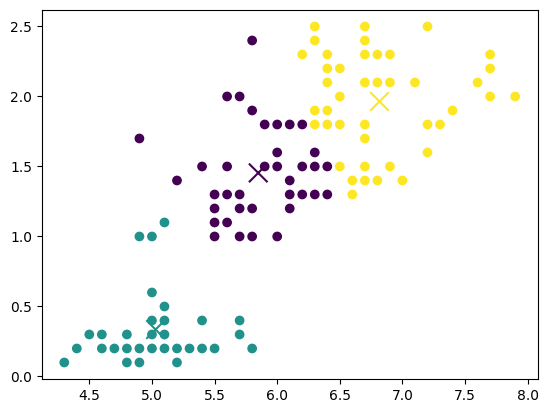

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2]


In [159]:
plt.scatter(*np.transpose(iris_objects), c=assignments)
plt.scatter(*np.transpose(cluster_centers), c=range(k), s=180, marker="x")
plt.show()

print(assignments)

A similarity to the plot visualized earlier based on the classes should be visible, and the cluster centers should lie centrally in the objects assigned to them.

## 3: Choosing the appropriate distance measure
The distance measure also plays an important role in assigning objects to clusters.

So far, the squared Euclidean distance has been used in this example. 
The Euclidean distance is often considered the standard, which most people also know from school, since it intuitively corresponds to the length of a straight line segment spanned between two points.
A simple measure like this is also recommended to keep computational complexity low.

For machine learning, other distances are also used depending on the type and dimensionality of the data. 
Some known alternatives are for example the Manhattan distance (L1 norm) or the Mahalanobis distance. 

The **Manhattan distance**
$ d_1(\mathbf{\vec{x}}, \mathbf{\vec{y}})=\|\mathbf {\vec{x}} -\mathbf {\vec{y}} \|_{1}=\sum _{i=1}^{n}(|x_{i}-y_{i}|) $ 
is used to calculate distances in a graph arranged as a grid. In the following graph all red points have the distance $2$ to the blue point.

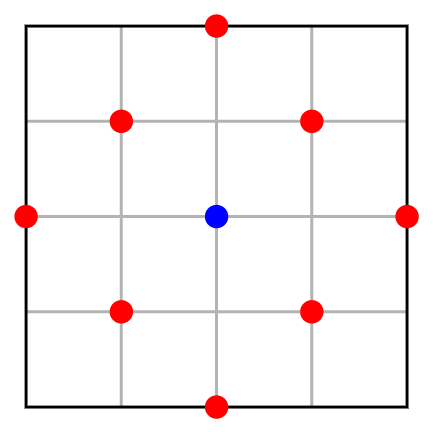

The Manhattan distance can also be used for particularly high-dimensional data, since its values do not approach $1$ (unlike other distances such as the Euclidean norm) as dimensionality increases [[source](https://stats.stackexchange.com/a/99191)].

The **Mahalanobis distance** 
$ d_C(\mathbf{\vec{x}}, \mathbf{\vec{y}}) = \sqrt{(\mathbf{\vec{x}} -\mathbf{\vec{y}} )^{\top }\mathbf{C} ^{-1}(\mathbf{\vec{x}} -\mathbf{\vec{y}} )} $
with the covariance matrix $\mathbf{C}$ of all points of the dataset
uses the standard deviations of the points and is therefore scale and translation invariant. It is used to detect outliers.

<!-- The covariance matrix $\mathbf{C}$ of a matrix $X$ containing row-wise all points $\vec{x}$ of the data set is defined as:

$ \mathbf{C}(\mathbf{X}) = \begin{pmatrix}\mathbf{Var}(X_{1}) & \mathbf{Cov}(X_{1},X_{2}) & \cdots & \mathbf{Cov}(X_{1},X_{n}) \\ \mathbf{Cov}(X_{2},X_{1}) & \mathbf{Var}(X_{2}) & \cdots & \mathbf{Cov}(X_{2},X_{n})\\\vdots & \vdots & \ddots & \vdots \\ \mathbf{Cov}(X_{n},X_{1}) & \mathbf{Cov}(X_{n},X_{2}) & \cdots & \mathbf{Var}(X_{n})\end{pmatrix} $

In this case, we do not have the full propability distribution at hand and can not calculate the random variables needed. Instead, we use the **sample covariance** defined as 

$\Sigma = \frac{1}{n-1} \left( (X - \bar{x})^T\;(X - \bar{x})) \right)  \in \R^{d \times d}$ 
with the mean vector $\bar{x} = \frac{1}{n} \sum\limits_{i=1}^n x_{i} \in \mathbb{R}^d$ containing the mean for each column in the dataset $ X $.

Each element $ \sigma_{jk} \in \Sigma $ represents the covariance between two features.  -->


<!-- $\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{n}\left( x_{ij}-\bar{x}_j \right) \left( x_{ik}-\bar{x}_k \right).$ -->

<!-- In code, the calculation of the covariance matrix can be done using numpy. -->


In the graph shown (after [Woźniak et. al. 2019](https://www.researchgate.net/publication/334035854_Application_of_Mossbauer_spectroscopy_multidimensional_discriminant_analysis_and_Mahalanobis_distance_for_classification_of_equilibrated_ordinary_chondrites/figures?lo=1)), the two points $d_1$ and $d_2$ have the same distance to $(x_1,x_2)$, while $d_3$ has a larger distance.

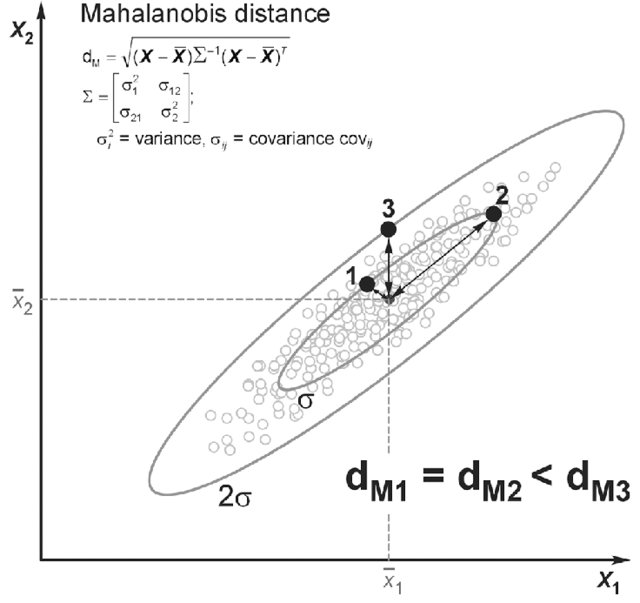

If we would use Euclidean distance instead, obviously $d_2$ would be the point with the largest distance.

### 3.1: ✏️ Implementation of the distance functions
To use these distance functions for k-means, they must be available as Python functions.

For the purposes of the exercise, only numpy functions should be used, no ready-to-use distance functions.
1. Implement the Manhattan Distance


In [160]:
def manhattan_distance(point_a, point_b, points=None):
    """Calculate the manhattan distance of two points"""

    # TODO: Implement
    distance = 0
    for dim in range(len(point_a)):
        distance += abs(point_a[dim] - point_b[dim])
    return distance
#manhattan_distance((1,2,3),[4,5,6])

2. Implement the Mahalanobis Distance. If you get the "``LinAlgError: Singular matrix``", use the [pseudo-inverse](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) method.

In [161]:
def mahalanobis_distance(point_a, point_b, points):
    """Calculate the mahalanobis distance of two points"""

    # TODO: Implement
    point_a = np.array(point_a)
    point_b = np.array(point_b)
    points = np.array(points)

    # Compute covariance matrix
    cov_matrix = np.cov(points.T) # Transpose oder rowvar=False

    
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        inv_cov_matrix = np.linalg.pinv(cov_matrix)

    #verschiebung in den center denk ich mal ka obs stimmt is intuitiv der erste Gedanke
    delta = point_a - point_b   
    
    distance = np.sqrt(delta.T @ inv_cov_matrix @ delta)
    return distance
 

3. Verify the result of your implementations using the functions from ``scipy.spatial.distance`` ([Documentation](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)) by calculating the distances between the points $u$ and $v$.

In [162]:
u = np.array([3,5,6,1])
v = np.array([6,5,5,8])

# TODO: Implement
print("own",manhattan_distance(u,v), "lib", sd.cityblock(u,v))

points = np.array([u, v])


cov_matrix2 = np.cov(points,rowvar=False)
inv_cov_matrix2 = np.linalg.pinv(cov_matrix2)

# falsch warum ka aber es müsste 1.414
#erklärung die Daten werden als jede zeile ist ein feature und jede spalte eine Beobachtung aber die U V array dataen sind ein array vom typ shape (2,4).
# also hätten wir 2 features und 4 beobachtungen was falsch ist da die COV funktion das so annimmt. wir haben ja 4 features mit 2 beobachtungen also müssen wir rowvar=False als argument nehen um das zu korrigieren



print("own", mahalanobis_distance(u, v,points ), "lib", sd.mahalanobis(u, v, inv_cov_matrix2))



own 11 lib 11
own 1.414213562373095 lib 1.414213562373095


### 3.2: Calling K-Means and visualization
Subsequently, the function of the K-Means loop can be used again (twice), whereby only the distance functions must be exchanged in each case.

Note: If not already implemented in this way, the total set of points (`points`) must now also be passed to the distance functions in the `assignment()` function.

In [163]:
"""
[(6.6, 1.3), (4.9, 1.7), (7.6, 2.1)]
k=3: Centers after 8 iterations: [(5.91, 1.46), (5.03, 0.34), (6.85, 2.01)]
[(6.6, 1.3), (4.9, 1.7), (7.6, 2.1)]
k=3: Centers after 7 iterations: [(5.12, 0.35), (5.99, 1.76), (6.88, 1.7)]
"""

assignments_manhattan, cluster_centers_manhattan = kmeans_loop(
    k, iris_objects, init_cluster_centers, manhattan_distance
)

assignments_mahalanobis, cluster_centers_mahalanobis = kmeans_loop(
    k, iris_objects, init_cluster_centers, mahalanobis_distance
)

[(5.1, 0.2), (4.9, 0.2), (4.7, 0.2), (4.6, 0.2), (5.0, 0.2), (5.4, 0.4), (4.6, 0.3), (4.4, 0.2), (4.9, 0.1), (5.4, 0.2), (4.8, 0.2), (4.8, 0.1), (4.3, 0.1), (5.8, 0.2), (5.7, 0.4), (5.1, 0.3), (5.7, 0.3), (5.1, 0.4), (5.1, 0.5), (5.0, 0.4), (5.2, 0.2), (5.2, 0.1), (5.5, 0.2), (5.0, 0.3), (4.5, 0.3), (5.0, 0.6), (4.8, 0.3), (5.3, 0.2), (7.0, 1.4), (6.4, 1.5), (6.9, 1.5), (5.5, 1.3), (6.5, 1.5), (5.7, 1.3), (6.3, 1.6), (4.9, 1.0), (6.6, 1.3), (5.2, 1.4), (5.0, 1.0), (5.9, 1.5), (6.0, 1.0), (6.1, 1.4), (5.6, 1.3), (6.7, 1.4), (5.6, 1.5), (5.8, 1.0), (6.2, 1.5), (5.6, 1.1), (5.9, 1.8), (6.1, 1.3), (6.3, 1.5), (6.1, 1.2), (6.4, 1.3), (6.6, 1.4), (6.8, 1.4), (6.7, 1.7), (6.0, 1.5), (5.7, 1.0), (5.5, 1.1), (5.5, 1.0), (5.8, 1.2), (6.0, 1.6), (5.4, 1.5), (6.7, 1.5), (6.3, 1.3), (5.5, 1.2), (5.7, 1.2), (6.2, 1.3), (5.1, 1.1), (6.3, 2.5), (5.8, 1.9), (7.1, 2.1), (6.3, 1.8), (6.5, 2.2), (7.6, 2.1), (4.9, 1.7), (7.3, 1.8), (6.7, 1.8), (7.2, 2.5), (6.5, 2.0), (6.4, 1.9), (6.8, 2.1), (5.7, 2.0), (5.

Finally, the plots can be compared for visualization.

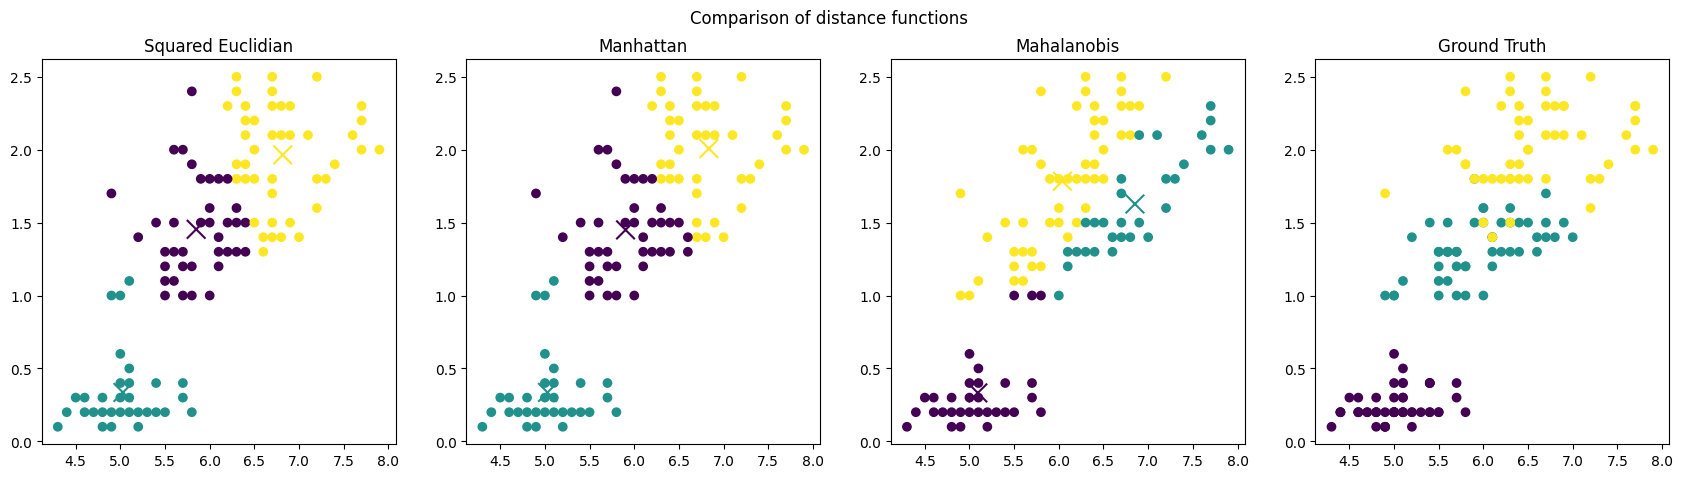

In [164]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(21,5))
fig.suptitle('Comparison of distance functions')

ax1.set_title('Squared Euclidian')
ax1.scatter(*np.transpose(iris_objects), c=assignments)
ax1.scatter(*np.transpose(cluster_centers), c=range(k), s=180, marker="x")

ax2.set_title('Manhattan')
ax2.scatter(*np.transpose(iris_objects), c=assignments_manhattan)
ax2.scatter(*np.transpose(cluster_centers_manhattan), c=range(k), s=180, marker="x")

ax3.set_title('Mahalanobis')
ax3.scatter(*np.transpose(iris_objects), c=assignments_mahalanobis)
ax3.scatter(*np.transpose(cluster_centers_mahalanobis), c=range(k), s=180, marker="x")

ax4.set_title('Ground Truth')
ax4.scatter(df["sepal_length"], df["petal_width"], c=df["class_id"])
plt.show()

The first two distance functions are already very similar in the formulas, which is why there are only small differences in the assignment and final cluster centers in our data.

In contrast to these, the Mahalanobis distance forms completely different clusters.

Determining which of the functions is more suitable can be done both visually and by comparing the results to the groundtruth, depending on the application (of course, the colors do not have to match - the clusters created by k-means have no order or labels).

## 4: Selecting an appropriate $k$.
In the above example, we used $k=3$ because we knew from domain knowledge that there are three different flowers in the dataset.

In practice, the ideal number of clusters is often unknown. 
Here, _ideal_ means for us that the objects in a cluster are arranged close to each other (compact) and that the different clusters are well distinguishable from each other.

To determine the best $k$, the **silhouette coefficient** can be used.

Here, the k-means algorithm is applied for different $k\in{2,...,n}$ and then the result with the best silhouette coefficient is chosen.

Calculate for each object $\vec{x}$ 

- the **distance to own cluster** $ C_{\vec{x}}^0$: $ a_{\vec{x}} = d(\vec{x}, C_{\vec{x}}^0) $
- the **distance to the nearest cluster** $ C_{\vec{x}}^1$: $ b_{\vec{x}} = d(\vec{x}, C_{\vec{x}}^1) $
- the **silhouette** $ d_{\vec{x}} = \frac{b_{\vec{x}} - a_{\vec{x}}}{\max\{a_{\vec{x}}, b_{\vec{x}}\}} =   \begin{cases}
    1 - \frac{a_{\vec{x}}}{b_{\vec{x}}}  & \in [0, 1]   & \quad \text{if } a_{\vec{x}} \leq b_{\vec{x}}\\
    \frac{b_{\vec{x}}}{a_{\vec{x}}} - 1  & \in [-1, 0]  & \quad \text{if } a_{\vec{x}} \gt b_{\vec{x}}
  \end{cases}
$

The average of all silhouettes in the dataset is called the **silhouette coefficient**. It is $\in [-1,1]$, with high values close to $1$ indicating particularly good clusters. 

If the respective silhouette coefficient is now calculated for different $k$, the $k$ with the highest silhouette coefficient can be considered ideal.

### 4.1: ✏️ Implementation of the silhouette function
The formulas described above should now be implemented as code.

1. Implement the method for determing the closest cluster

In [165]:
def get_next_cluster(x, own_cluster_center, cluster_centers, distance_function):
    """return the center of the next (smallest distance) cluster"""
    # TODO: Implement
    
    own_Dist = distance_function(x,own_cluster_center)
    temp_Dist = own_Dist
    closest_center = own_cluster_center
    for center in cluster_centers:
        calculated_Dist = distance_function(x,center)
        if(calculated_Dist <= temp_Dist):
            temp_Dist = calculated_Dist
            closest_center = center

    return closest_center

2. Implement the silhouette function

In [166]:
def silhouette(x, own_cluster_center, cluster_centers, distance_function):
    # TODO: Implement
    a = distance_function(x,own_cluster_center)
    nearest_cluster = get_next_cluster(x,own_cluster_center,cluster_centers,distance_function)
    b = distance_function(x,nearest_cluster)
    erg = np.nan
    if a <= b:
        erg = 1 - (a/b)
        print("§erg: ", erg )
    else:
        erg = (b/a) - 1
        print("§erg: ", erg )
        
    
    return erg    
    

### 4.2: ✏️ Implementation of the silhouette coefficient function
The silhouette should be calculated for all objects in a dataset so that the silhouette coefficient can be determined.

1. Implement the loop that calculates silhouettes and then determine the silhouette coefficient

In [167]:
def silhouette_coefficient(objects, assignments, cluster_centers, distance_function):
    """calculate all silhouettes and return the mean of them"""
    
    # TODO: Implement
    silhouettes = []
    for i, x in enumerate(objects):
        own_cluster_index = assignments[i]
        own_cluster_center = cluster_centers[own_cluster_index]
        s = silhouette(x, own_cluster_center, cluster_centers, distance_function)
        silhouettes.append(s)
        print("sil coeff: " , sum(silhouettes) / len(silhouettes))
    return sum(silhouettes) / len(silhouettes)       


### 4.3: ✏️ Performing the calculations and determining the best $k$
With these methods we can now calculate the silhouette of all objects and thus the silhouette coefficient for different $k$.

Afterwards, the most suitable $k$ can be determined.

In this example the distance function `squared_euclidean_distance` and $n=7$ shall be used. 

1. Implement the loop for different k and then determine the k with the highest silhouette coefficient

In [168]:
n = 7
# creates lists of length (n+1) with values np.NaN
# e.g. cluster_centers_k[3] contains all cluster_centers for k=3
init_cluster_centers_k = [np.nan] * (n + 1)
assignments_k = [np.nan] * (n + 1)
cluster_centers_k = [np.nan] * (n + 1)
silhouette_coefficient_k = [-np.inf] * (n + 1)

for i_k in range(2, n + 1):
    # Initialize cluster centers by randomly sampling k points from objects
    initial_centers = get_random_cluster_centers(i_k,iris_objects)
    init_cluster_centers
    # Run kmeans with your given kmeans_loop function
    assignments, cluster_centers = kmeans_loop(i_k, iris_objects, initial_centers, squared_euclidean_distance)
    
    assignments_k[i_k] = assignments
    cluster_centers_k[i_k] = cluster_centers
    
    silhouette_coefficient_k[i_k] = silhouette_coefficient(iris_objects, assignments, cluster_centers, squared_euclidean_distance)

best_k = np.argmax(silhouette_coefficient_k)
print("best k:", best_k)


[(5.1, 0.2), (4.9, 0.2), (4.7, 0.2), (4.6, 0.2), (5.0, 0.2), (5.4, 0.4), (4.6, 0.3), (4.4, 0.2), (4.9, 0.1), (5.4, 0.2), (4.8, 0.2), (4.8, 0.1), (4.3, 0.1), (5.8, 0.2), (5.7, 0.4), (5.1, 0.3), (5.7, 0.3), (5.1, 0.4), (5.1, 0.5), (5.0, 0.4), (5.2, 0.2), (5.2, 0.1), (5.5, 0.2), (5.0, 0.3), (4.5, 0.3), (5.0, 0.6), (4.8, 0.3), (5.3, 0.2), (7.0, 1.4), (6.4, 1.5), (6.9, 1.5), (5.5, 1.3), (6.5, 1.5), (5.7, 1.3), (6.3, 1.6), (4.9, 1.0), (6.6, 1.3), (5.2, 1.4), (5.0, 1.0), (5.9, 1.5), (6.0, 1.0), (6.1, 1.4), (5.6, 1.3), (6.7, 1.4), (5.6, 1.5), (5.8, 1.0), (6.2, 1.5), (5.6, 1.1), (5.9, 1.8), (6.1, 1.3), (6.3, 1.5), (6.1, 1.2), (6.4, 1.3), (6.6, 1.4), (6.8, 1.4), (6.7, 1.7), (6.0, 1.5), (5.7, 1.0), (5.5, 1.1), (5.5, 1.0), (5.8, 1.2), (6.0, 1.6), (5.4, 1.5), (6.7, 1.5), (6.3, 1.3), (5.5, 1.2), (5.7, 1.2), (6.2, 1.3), (5.1, 1.1), (6.3, 2.5), (5.8, 1.9), (7.1, 2.1), (6.3, 1.8), (6.5, 2.2), (7.6, 2.1), (4.9, 1.7), (7.3, 1.8), (6.7, 1.8), (7.2, 2.5), (6.5, 2.0), (6.4, 1.9), (6.8, 2.1), (5.7, 2.0), (5.

### 4.4: Visualization of the different $k$
Finally, we can take a look at the assignment of objects at different $k$.

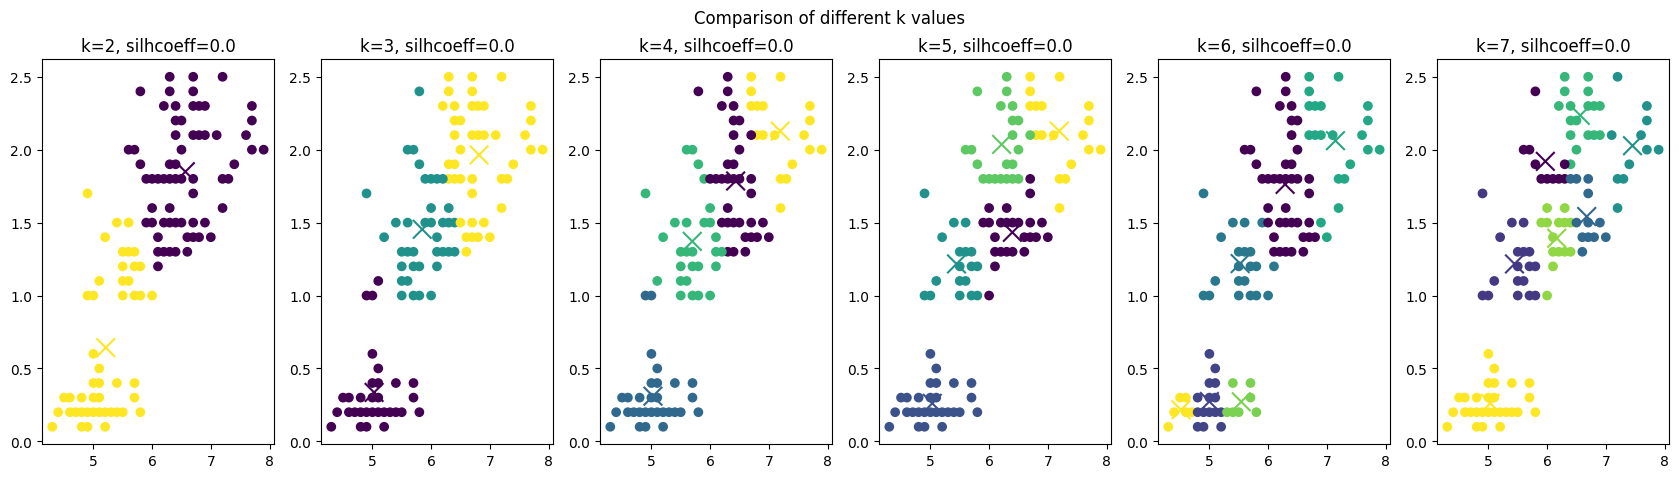

In [169]:
fig, axes = plt.subplots(1, n-1, figsize=(21,5))
fig.suptitle('Comparison of different k values')

for i_k in range(2, n+1):
    axes[i_k-2].set_title('k='+str(i_k)+', silhcoeff='+str(round(silhouette_coefficient_k[i_k],2)))
    axes[i_k-2].scatter(*np.transpose(iris_objects), c=assignments_k[i_k])
    axes[i_k-2].scatter(*np.transpose(cluster_centers_k[i_k]), c=range(i_k), s=180, marker="x")

plt.show()

Visually, the clusters should now look both compact in themselves and separate from each other.